## ML-Regression Project:&nbsp;&nbsp;  Real Estate Price Prdeiction in Tel-Aviv

In this project we will try to predict apartment prices in Tel-Aviv by using information from real estate ads in a website selling used apartments.

The motivation was to work with data from the nearby "real world" -one that we can relate to and (hopefully) understand.

The steps that we undertook to get the desirable data: 

**First** - scraping apartment ads from "https://www.ad.co.il/nadlansale" with selenium (the function below) 

**Secondly**- adding coordinates with geopy's package and its online connection to Nominatim tool

**Thirdly** - storing the data in excel files to be used later-on

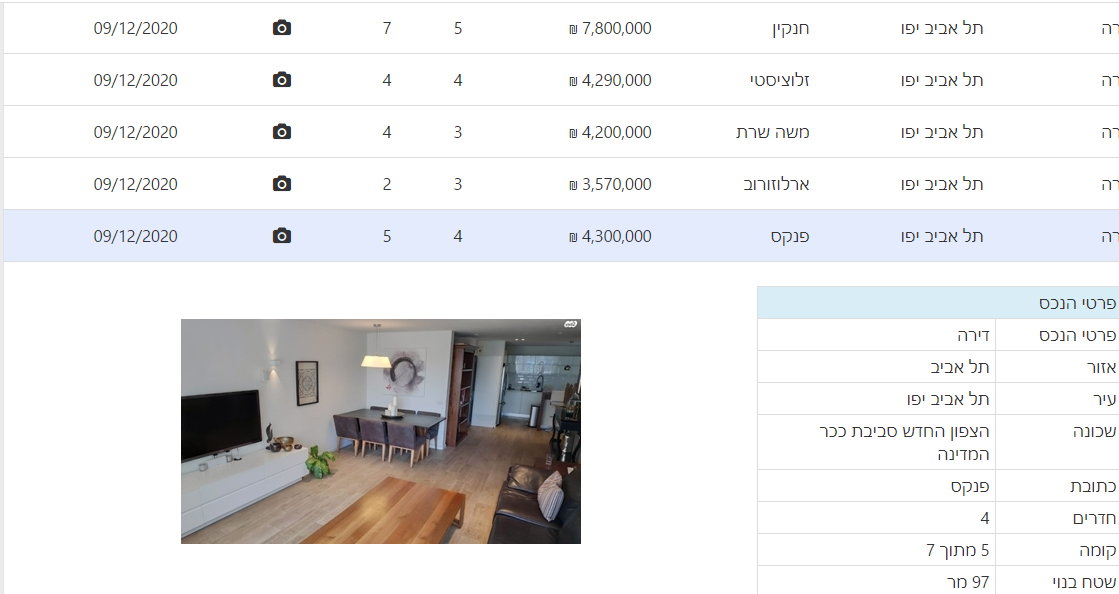

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

The scraping Function:

In [2]:

import numpy as np
import pandas as pd
from selenium import webdriver      #  selenium should be pip installed
from bs4 import BeautifulSoup as bs                 
import time
import requests 
import os
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim  
import re
from geopy.extra.rate_limiter import RateLimiter
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


pd.options.display.float_format = '{:.10f}'.format

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def table_to_excel(name, df):  
          
    data_dir = 'real_estate_table'

    if data_dir not in os.listdir():
        os.mkdir(data_dir)  
        
    df.to_excel(f'real_estate_table\\{name}_real_estate.xlsx')
    
    
    
def scraper ():
    
    max_pages= find_max_pages()
       
    df_final= pd.DataFrame()
    
    if max_pages<50:   # scrape a max numnber of 50 pages
        pages = max_pages
    else: 
        pages = 50

    for i in range(pages):  # 50 or less
    
    #click to open all info:       
        driver.find_element_by_xpath('/html/body/div/div/div/div[4]/a').click()

    # get table:    
        driver.find_element_by_xpath('/html/body/div/div/div/div[4]/table/tbody/tr[2]/td/div/div/div[1]/table')                      

        html=driver.page_source
       
        df= pd.read_html(html)[0]
    
    #combine with large table:
        df_final= df_final.append(df)

# click next 
        driver.find_element_by_xpath('/html/body/div/div/div/div[6]/ul/li[12]/a').click()

        time.sleep(4)
    
    return df_final


def find_max_pages():
    
    driver.find_element_by_xpath(r'/html/body/div/div/div/div[1]/div/div[3]/div/p/span')
    
    total_pages= driver.page_source

    soup=bs(total_pages,'html.parser')
    
    text =str(soup.find_all('span',class_="pagerHider"))

    max_num_pages= int(re.findall('\d+',text)[-1] ) 
    
    return max_num_pages


def cleaning_info(df_final):
    
    df_info = df_final.iloc[:,:2].reset_index()

    df_info= df_info[df_info['סוג הנכס'].isin([	'סוג הנכס', 'פרטי הנכס', 'אזור', 'עיר', 'שכונה' , 'כתובת' , 'חדרים', 'קומה', 'שטח בנוי', 'תאריך כניסה'])]

    df_info.columns=['index','type','info']
    
    df_info['check']= df_info['info']=='פרטי הנכס'  
     
    df_info['indexer']= 1
    
    j=0
    # indexing each apartment: 
    for i in range (df_info.shape[0]):
        if df_info.iloc[i,3] == True:
            df_info.iloc[i,4] = j+1
            j=j+1
        else:
            df_info.iloc[i,4] = j
    
          
    df_info=df_info[df_info['info']!=	'פרטי הנכס']
      
    df_info_pivot= df_info.pivot(index='indexer',columns='type', values='info')

    return df_info_pivot



def cleaning_price (df_final):
        
    df_price= df_final.dropna(thresh=3)
    
    df_price= df_price[ df_price.apply(lambda x: x.str.contains("פרטי")==False, axis=1)]
    
    df_price= df_price.dropna(thresh=1 )
    
    df_price.columns= ['סוג הנכס', 'ישוב', 'רחוב', 'price', 'חד', 'קומה', 'תמונה', 'date_ad']
    
    return df_price


def combine_add_coordinates (df_info, df_price ) :

    df_combined= pd.concat([df_price[['date_ad','price']].reset_index(),df_info.reset_index(drop=True)], axis=1)
    
    df_combined.columns= ['index','date_ad', 'price', 'region', 'rooms', 'address', 'city','type', 'floor', 'size', 'hood', 'entry_date' ]
    
    df_clean= df_combined.drop_duplicates(subset=  ['region', 'rooms', 'address', 'city','type', 'floor', 'size', 'hood'])
    
    df_clean= df_clean.dropna(subset=['rooms', 'address', 'price'])
    
    df_clean['full_address']= df_clean['city']+' '+df_clean['address']
    
    geolocator = Nominatim(user_agent="my_user_agent")
    
    df_clean['coordinates']= df_clean['full_address'].map(lambda x: (geolocator.geocode(x)) )
    
    df_clean['coordinates']= df_clean[~df_clean ['coordinates'].isna() ] ['coordinates'] .map(lambda x: (x.latitude, x.longitude))
    
    df_clean['price']=df_clean['price'].str[:-2].replace('[\$,]', '', regex=True).fillna(0).astype('float')
    
    return df_clean



###############################################################
while True :
    to_scrape= input("scrape tables? y/n----")
    
    if to_scrape == 'y':    
               
        driver_path= r"C:\Users\Roy\Desktop\DATA SCIENCE\Python\chromdriver\chromedriver.exe"
                
        driver = webdriver.Chrome(driver_path)
              
        tel_aviv = r'https://www.ad.co.il/nadlansale?view=table&sp1=1&sp2=61%2c123%2c51%2c2%2c124%2c35%2c118&sp3=62'
        petah_tikva = r'https://www.ad.co.il/nadlansale?view=table&sp2=61%2c123%2c51%2c2%2c124%2c35%2c118&sp3=3&sp1=1'
        rishon_lezion= r'https://www.ad.co.il/nadlansale?view=table&sp2=61%2c123%2c51%2c2%2c124%2c35%2c118&sp3=169&sp1=1'
        holon       = r'https://www.ad.co.il/nadlansale?view=table&sp2=61%2c123%2c51%2c2%2c124%2c35%2c118&sp3=166&sp1=1'
        ramat_gan   = r'https://www.ad.co.il/nadlansale?view=table&sp2=61%2c123%2c51%2c2%2c124%2c35%2c118&sp3=191&sp1=1'
        bat_yam     = r'https://www.ad.co.il/nadlansale?view=table&sp2=61%2c123%2c51%2c2%2c124%2c35%2c118&sp3=165&sp1=1'
        givatayim   = r'https://www.ad.co.il/nadlansale?view=table&sp3=52&sp2=51&sp1=1'
        herzeliya   = r'https://www.ad.co.il/nadlansale?view=table&sp2=127&sp3=173&sp1=1'
        
        beer_sheva  = r'https://www.ad.co.il/nadlansale?view=table&sp2=97&sp3=98&sp1=1'
        kiryat_gat  = r'https://www.ad.co.il/nadlansale?view=table&sp2=97&sp3=233&sp1=1'
        
        jerusalem   = r'https://www.ad.co.il/nadlansale?view=table&sp2=29&sp3=30&sp1=1'
        
        haifa       = r'https://www.ad.co.il/nadlansale?view=table&sp2=122&sp3=167&sp1=1'
        
        rehovot     = r'https://www.ad.co.il/nadlansale?view=table&sp2=130&sp3=175&sp1=1'
        ashdod      = r'https://www.ad.co.il/nadlansale?view=table&sp2=42&sp3=43&sp1=1'
        ashkelon    = r'https://www.ad.co.il/nadlansale?view=table&sp2=42&sp3=77&sp1=1'
        
        kfar_saba   = r'https://www.ad.co.il/nadlansale?view=table&sp2=131&sp1=1&sp3=176'
        raanana     = r'https://www.ad.co.il/nadlansale?view=table&sp2=131&sp3=187&sp1=1'
        natanya     = r'https://www.ad.co.il/nadlansale?view=table&sp3=182&sp2=133&sp1=1'
        
        hedera      = r'https://www.ad.co.il/nadlansale?view=table&sp2=129&sp3=217&sp1=1'
        afula       = r'https://www.ad.co.il/nadlansale?view=table&sp2=132&sp3=242&sp1=1'
        naaria     = r'https://www.ad.co.il/nadlansale?view=table&sp2=125&sp3=205&sp1=1'
        
        ramla      = r'https://www.ad.co.il/nadlansale?view=table&sp2=135&sp3=226&sp1=1'
        lod        = r'https://www.ad.co.il/nadlansale?view=table&sp2=135&sp3=188&sp1=1'


        urls=[rehovot]  #rehovot,ashdod,ashkelon,kfar_saba,raanana,natanya,hedera, afula  ] 
#urls=[tel_aviv, petah_tikva,rishon_lezion,holon ,ramat_gan,bat_yam,givatayim,herzeliya,beer_sheva,kiryat_gat,jerusalem ,haifa,rehovot,ashdod,ashkelon,kfar_saba,raanana,natanya,hedera, afula, naaria, ramla, lod,   ] 

#cities_names=  ['Tel_Aviv', 'Petah_Tikva,'Rishon_Lezion','Holon' ,'Ramat_Gan', 'bat_yam','givatayim','herzeliya','beer_sheva','kiryat_gat','jerusalem' ,'haifa','rehovot','ashdod','ashkelon','kfar_saba','raanana','natanya','hedera', 'afula'  ]
        cities_names=  ['Rehovot']#,'ashdod','ashkelon','kfar_saba','raanana','natanya','hedera', 'afula','naaria', 'ramla' ,'Lod' ]

        for i in range(len(urls)) :
        
            driver.get(urls[i])
        
            driver.set_window_size(1024, 600)
            
            driver.maximize_window()
        
            df_full = scraper()
                
            df_info= cleaning_info (df_full)
            
            df_price= cleaning_price (df_full)
            
            df_final= combine_add_coordinates(df_info, df_price ).drop('index', axis=1).reset_index(drop=True)
            
            table_to_excel(cities_names[i], df_final)
            
            time.sleep(3)
            
    elif to_scrape == 'n':
        break
    else:
        print("\nplease enter valid input\n")
            
hide_toggle()    

scrape tables? y/n----n


retrieving table from excel files:

In [3]:

cities_names=  ['Tel_Aviv', 'Petah_Tikva','Rishon_Lezion','Holon' ,
                'Ramat_Gan', 'Bat_Yam','Givatayim','Herzeliya',
                'Beer_Sheva','Kiryat_Gat','Jerusalem', 'Haifa',
                'Rehovot','Ashdod','Ashkelon','Kfar_Saba','Raanana',
               'Natanya','Hadera', 'Afula','Ramla','Lod','Kiryat_Ata','Kiryat_Motzkin'] 


cities_dict= {}

path = 'C://Users//shpri//Desktop//Data Science//roy_exe//real_estate_tables_updated//'

for i in cities_names : 
    cities_dict[i]= pd.read_excel (path+i+'_real_estate.xlsx')


df = cities_dict['Tel_Aviv']

hide_toggle()

In [4]:
df

,Unnamed: 0,date_ad,price,region,rooms,address,city,type,floor,size,hood,entry_date,full_address,coordinates
0,0,2020-12-09,2780000,תל אביב,5.0000000000,שתולים,תל אביב יפו,דירה,5 מתוך 18,124 מר,עזרא,NaN,תל אביב יפו שתולים,"(32.0446368, 34.7953464)"
1,1,2020-12-09,3950000,תל אביב,3.0000000000,סירקין 25,תל אביב יפו,דירה,2 מתוך 4,NaN,הצפון הישן החלק הדרום מערבי,NaN,תל אביב יפו סירקין 25,"(32.079229, 34.770318)"
2,2,2020-12-09,2900000,תל אביב,2.0000000000,תל חי,תל אביב יפו,דירה,2 מתוך 3,60 מר,הצפון הישן החלק הדרום מזרחי,מיידית,תל אביב יפו תל חי,"(32.0771561, 34.7758716)"
3,3,2020-12-09,2290000,תל אביב,4.0000000000,נתן אלבז 1,תל אביב יפו,דירה,4 מתוך 9,NaN,נוה אליעזר,NaN,תל אביב יפו נתן אלבז 1,"(32.051881, 34.807227)"
4,4,2020-12-09,4150000,תל אביב,4.0000000000,אבשלום חביב,תל אביב יפו,דירה,1 מתוך 15,115 מר,רמת אביב ג,2021-07-31 00:00:00,תל אביב יפו אבשלום חביב,"(32.1257138, 34.7981542)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593,2593,2020-08-13,3850000,תל אביב,4.0000000000,החשמונאים,תל אביב יפו,דירה,20 מתוך 20,9 מר,לב תל אביב החלק הצפוני,מיידית,תל אביב יפו החשמונאים,"(32.0696177, 34.7823403)"
2594,2594,2020-08-12,4100000,תל אביב,3.0000000000,הירקון,תל אביב יפו,דירה,1 מתוך 3,75 מר,הצפון הישן החלק הדרום מערבי,NaN,תל אביב יפו הירקון,"(32.0957586, 34.77448)"
2595,2595,2020-08-12,1930000,תל אביב,3.0000000000,יסוד המעלה,תל אביב יפו,דירה,3 מתוך 3,62 מר,נוה שאנן,מיידית,תל אביב יפו יסוד המעלה,"(32.0588174, 34.7806256)"
2596,2596,2020-08-12,3500000,תל אביב,3.0000000000,בן יהודה 198,תל אביב יפו,דירה,6 מתוך 7,66 מר,הצפון הישן החלק הצפוני,NaN,תל אביב יפו בן יהודה 198,"(32.0852997, 34.7818064)"


we can see below that prices in Tel-Aviv are varied but still close to a normal distribution-  with a "long tail" approching the higher prices range

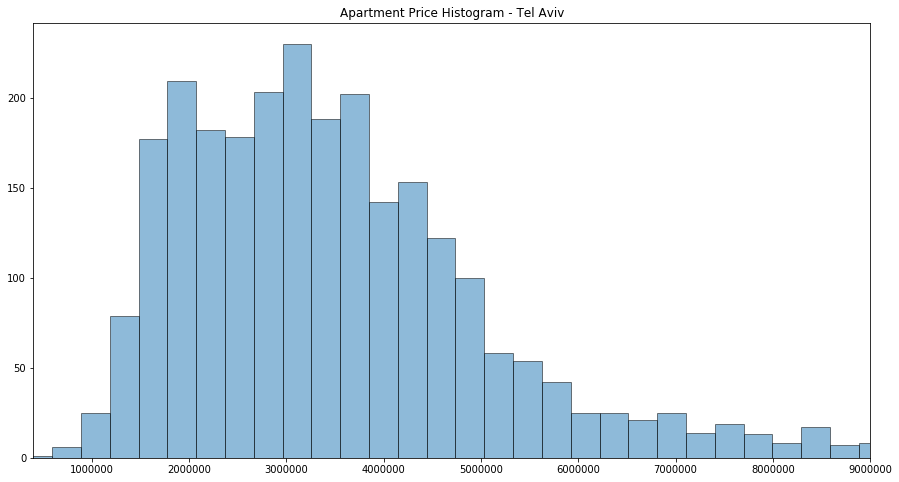

       Unnamed: 0      price  rooms
count      2598.0     2598.0 2598.0
mean       1298.5  3676826.4    3.5
std         750.1  2328378.5    1.0
min           0.0     3200.0    1.0
25%         649.2  2300000.0    3.0
50%        1298.5  3260000.0    3.0
75%        1947.8  4350000.0    4.0
max        2597.0 37000000.0   12.0


In [5]:
import numpy
pd.options.display.float_format = '{:.1f}'.format
fig = plt.figure(figsize=(15,8))
ax = fig.gca()

plt.hist(df['price'], bins=125, alpha=0.5, histtype='bar', ec='black')
plt.xlim(400000, 9000000)
plt.title("Apartment Price Histogram - Tel Aviv")
plt.show()

print(df.describe())

***Creating a Pre-Processing function***

**first stage**:

cleans the features and converts them to numerical for each table passed: 

- rooms --> replacing extreme outlires with the average size of every room

- coordinates--->
             -filling N/A in both coordinates and hoods with the street average coordinates

             -filling N/A in coordinates with the neighborhood average coordinates
             
- neighborhood--> filling N/A in neighborhood with the neigborhood with shortest distance from coordinates (calculated with haversine function)

- price :  set a lower and upper limit range.  discard extreme outlires not inside this range. 

                                     
                                     
**second stage**: adding features
-  hood-class: one of 5 classes for each neighborhood from low-class to high class by deviation from average apartment price
-  western or eastern apartment by x-coordinate
-  southern or northern apartment by y-coordinate
-  top floor by floor number


In [6]:
        
def optimizing_table(df)   :
# converting non-numerical to numerical:
    
    #size of apartment:
    df['size']= df['size'].fillna('0').map(lambda x: int(''.join(re.findall('\d+',str(x)))) ).replace(0,np.nan)
    
    #floor number:
    if '2' not in df.columns:
        df[['floor_num','2','3']]=df['floor'].str.split(' ',expand=True)
    
    df= df.assign(floor_num= df['floor_num'].replace('קרקע',0))
    
    # add a "top floor" feature:
    df['top_floor']= np.where( df['floor_num']== df['3'], True, False  )
            
    df= df.drop(['2','3'], axis=1)
    
    df['floor_num'] =df['floor_num'].astype('float')
    
    # coordinates:
    df['y_coor']= df['coordinates'].fillna('00.0,').map(lambda x: (((re.findall("\d\d\.\d+?,",x))[0][:-1])) ). astype('float64')
    df['x_coor']= df['coordinates'].fillna(' 00.0').map(lambda x: (((re.findall(" \d\d\.\d+",x))[0])) ). astype('float64')
    
    
    ##############################################################
    #group by rooms and compute aggregate mean size for each room num
#then join it to the main df:
    
    mean_rooms_size=df.groupby('rooms')['size'].mean()
    
    df['meter_mean']=df['rooms'].map(mean_rooms_size)
    
    
    df['meter_mean_plus_std']= df['meter_mean']+ 2.5*df['rooms'].map(df.groupby(['rooms'])['size'].std())
    
    # add a column of mean minus 2.5 std's:
    df['meter_mean_minus_std']= df['meter_mean'] -2.5*df['rooms'].map(df.groupby(['rooms'])['size'].std())
          
    # if a size room bigger than mean+2.5*std or smaller than mean-2.5*STD change to mean:
    df['meter_final']=np.where( (df['size']<df['meter_mean_minus_std']) | (df['size']>df['meter_mean_plus_std']), df['meter_mean'], df['size'])
    
    df['meter_initial']  =   df['size'] 
    
    
    plt.scatter(df['rooms'],df['size'])
    
    plt.scatter(df['rooms'],df['meter_final'])
    
    ax=plt.axes()
    ax.set_xlim(1,8)
    ax.set_ylim(0, 250)
    ax.set_xlabel('rooms')
    ax.set_ylabel('size')
    
    plt.show()
    
    df['size_opt']= df['meter_final']
     
    # filling N/A in both coors and hoods with the street average corrs:
    df['street']= df['address'].astype('str').str.findall('\D+').map(lambda x: ''.join(x)).str.rstrip()
    df['street']=df['street'].str.strip()
    df_streets= df[(df['y_coor']!=0) & (df['x_coor']!= 0)]
    df_streets = pd.DataFrame([df_streets.groupby('street')['y_coor'].mean(),df_streets.groupby('street')['x_coor'].mean()]).T
    df_streets.columns= ['y_coor_avg_st', 'x_coor_avg_st']
    df= df.set_index('street').join(df_streets).set_index(df.iloc[:,0])
    
    # filling N/A in corrs with the neighborhood average corrs:
    avg_hood_cors= df[(df['y_coor']!=0) & (df['x_coor']!= 0)]
    avg_hood_cors = pd.DataFrame([avg_hood_cors.groupby('hood')['y_coor'].mean(),avg_hood_cors.groupby('hood')['x_coor'].mean()]).T
    avg_hood_cors.columns= ['y_coor_avg_h', 'x_coor_avg_h']
    df= df.set_index('hood').join(avg_hood_cors).reset_index()
    
    # case : choosing between fill hood or fill street
    df['y_coor_filled']= np.where(df['y_coor']!=0,df['y_coor'],np.where(df['hood']!=None,df['y_coor_avg_h'],df['y_coor_avg_st']) )
    df['x_coor_filled']= np.where(df['x_coor']!=0,df['x_coor'],np.where(df['hood']!=None,df['x_coor_avg_h'],df['x_coor_avg_st']) )
    
    # filling neighborhood with shortest distance from coors:
    
    df['real_coors_tuple']= df[['y_coor' ,'x_coor']].apply(lambda x:tuple(x),axis=1)
    avg_hood_cors ['h_coors_tuple']=avg_hood_cors [['y_coor_avg_h' ,'x_coor_avg_h']].apply(lambda x:tuple(x),axis=1)
    
    
    def min_dist (point1,avg_hood_cors):
        avg_hood_cors['distance']= avg_hood_cors['h_coors_tuple'].map(lambda point2 :haversine(point1[1],point1[0],point2[1],point2[0]) )
        return avg_hood_cors['distance'].idxmin() 
        
    
    df['new_hood']= df['real_coors_tuple'].map(lambda x: min_dist(x,avg_hood_cors) )
    
    df['hood_filled']= np.where(df['hood'].isnull()==False, df['hood'], df['new_hood'])
    
    
    # back to original form with filled coordinates and hood:  (still some cases with nulls)
    df= df[['date_ad', 'price', 'region', 'rooms', 'address', 'city',
           'type', 'floor_num','top_floor', 'size_opt', 'hood_filled', 'entry_date', 'full_address',
           'y_coor_filled','x_coor_filled']]
    
    
    # categorize the hoods - 1-lower , 2 -lower-medium, 3- medium, 4- upper-medium  5- upper
    
    df_hood= df.groupby('hood_filled')['price'].agg(mean= 'mean', median= 'median', count='count')
    
    
    # eliminating extreme outlires :
           # idea: the upper filter of price should be a city-wise filter
    price_lower_lim = df['price'].mean()-1.5*df['price'].std()
    price_upper_lim = df['price'].mean()+ 1.5*df['price'].std()  # Tel_Aviv = 8,200,000
    
    if price_lower_lim < 0:
        price_lower_lim = 500000
    elif price_lower_lim > 1000000:
        price_lower_lim = 1000000
        
        
    df_filtered= df[  (df ['price']<price_upper_lim ) & (df ['price']>price_lower_lim) & (df['size_opt']<250) & (df['size_opt']>20) & (df['floor_num'] <50)]
    
    # grouping by neigborhood, aggregates by mean, median price and num of apartments: 
    df_hood= df_filtered.groupby('hood_filled')['price'].agg(mean= 'mean', median= 'median', count='count')
    
    #eliminating neigborhoods that have less than 3 apratments:  
    df_hood= df_hood[df_hood['count']>2]
    
    
    # define category for each neighborhood, one of 4:
    upper_lim = df_filtered['price'].mean()+ df_filtered['price'].std()
    med_upper_lim = df_filtered['price'].mean()+ 0.5*df_filtered['price'].std()
    med_lower_lim = df_filtered['price'].mean()- 0.5*df_filtered['price'].std()
    low_lim = df_filtered['price'].mean()- df_filtered['price'].std()
    
    df_hood['hood_class'] = np.where(df_hood['mean']>upper_lim, 'upper', \
                              np.where( (df_hood['mean']<upper_lim)& (df_hood['mean']>med_upper_lim), 'upper_middle', \
                              np.where( (df_hood['mean']<med_upper_lim)& (df_hood['mean']>med_lower_lim), 'middle',\
                              np.where( (df_hood['mean']<med_lower_lim)& (df_hood['mean']>low_lim), 'lower_middle' ,  'lower' ))))    
    


   # categorizing floors : 0 , 1-7, 8-9, 10+  --DID NOT improve the model
   # df_filtered['floor_num']= np.where(df_filtered['floor_num']==0,'0', \ 
                             # np.where((df_filtered['floor_num']>1) & (df_filtered['floor_num']<8), '1-7', '8+'))
                              #np.where((df_filtered['floor_num']>8) & (df_filtered['floor_num']<10), '8-9', '10+'))) 
                                      
    # for tel aviv: adding a feature for a western or eastern apartment:                                     
    df_filtered['eastern']=  df_filtered['x_coor_filled']> 34.82
    
    df_filtered['southern'] =df_filtered['y_coor_filled']< 32.05
    
    #cleaning befre modeling (dropping None) :
    df_filtered= df_filtered.drop("entry_date", axis=1)
    df_filtered= df_filtered.dropna()  # model would not fit without dropping nulls

    df_filtered= df_filtered.reset_index(drop=True)    
    
    
    return df_filtered, df_hood, mean_rooms_size
hide_toggle()    

Next step is retrieving our stored table from excel and also loading another tel-aviv apartment prices table for training model purposes 

the function will operate on both tables



here below we plot the changes made to room sizes when encountred with extreme outlier (more than 2.5 STD's) - blue dots 


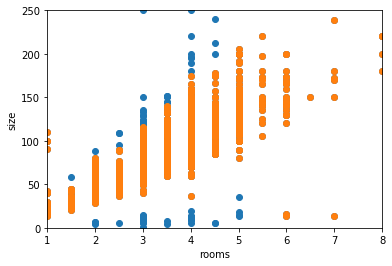

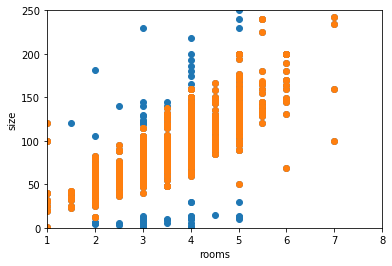

In [7]:
import warnings
warnings.filterwarnings('ignore')


cities_names=  ['Tel_Aviv']
               #  ,'Petah_Tikva','Rishon_Lezion','Holon' ,
               #  'Ramat_Gan', 'Bat_Yam','Givatayim','Herzeliya',
               #  'Beer_Sheva','Kiryat_Gat','Jerusalem', 'Haifa',
               #  'Rehovot','Ashdod','Ashkelon','Kfar_Saba','Raanana',
               # 'Natanya','Hadera', 'Afula','Ramla','Lod','Kiryat_Ata','Kiryat_Motzkin'] 


cities_dict= {}

path = 'C://Users//shpri//Desktop//Data Science//roy_exe//real_estate_tables_updated//'

for i in cities_names : 
    cities_dict[i]= pd.read_excel (path+i+'_real_estate.xlsx')


df = cities_dict['Tel_Aviv']


df_filtered, df_hoods, mean_rooms_size1= optimizing_table(df)


#retrieving training table for tel-aviv:
train_table, hoods_train, mean_rooms_size2 = optimizing_table(pd.read_excel (path+i+'_real_estate2.xlsx'))

hide_toggle()   

hood class was decided by using the second data table which our set "never seen"

In [8]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('precision',0)
df_hoods.sample(20).sort_values(['hood_class']).style.background_gradient(cmap='Wistia')
 

,mean,median,count,hood_class
hood_filled,,,,
ניר אביב,1843000,1910000,30,lower
התקווה,1489878,1380000,49,lower
תל חיים,2569667,2390000,15,lower_middle
פלורנטין,2361319,2370000,72,lower_middle
שפירא,2071000,1990000,30,lower_middle
יד אליהו,2245527,2150000,55,lower_middle
דקר,2177857,1785000,28,lower_middle
הצפון הישן החלק הדרום מערבי,3659438,3500000,64,middle
מעוז אביב א,3920000,3900000,5,middle


In [9]:
# neigberhood class is decided with an external data table that will not be used in modeling:
df_hoods= hoods_train

#classifing original data by hood type:                                 
df_filtered= df_filtered.set_index('hood_filled').join(df_hoods['hood_class'])
df_filtered= df_filtered.reset_index()
hide_toggle()   

#df_filtered.to_excel(r'C:\Users\shpri\Desktop\Data Science\roy_exe\real_estate\tel_aviv_filtered.xlsx')

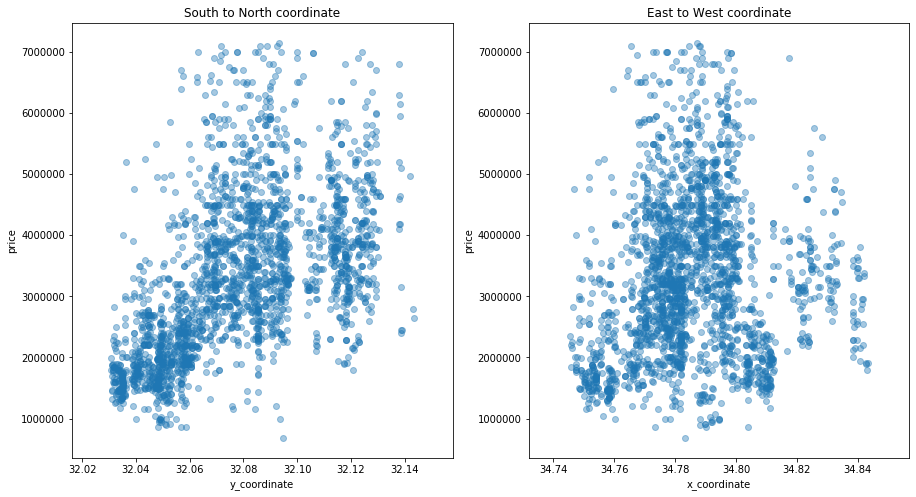

In [10]:
# prices vs x/y coordinate : 

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.scatter(df_filtered['y_coor_filled'], df_filtered['price'], alpha=0.4)
ax1.set_title('South to North coordinate')
ax2.set_title('East to West coordinate')
ax2.scatter(df_filtered['x_coor_filled'], df_filtered['price'], alpha=0.4)

ax1.set_xlabel('y_coordinate')
ax1.set_ylabel('price')
ax2.set_xlabel('x_coordinate')
ax2.set_ylabel('price')
hide_toggle()   

- y coordinate- more of a linear nature, ascending north means ascending prices
-  x coordinate-the linear nature stops at the 34.8 line. after that- as we go east the price decreases.

we will add:

--1. **western\eastern** feature

--2. **northern\southern** feature


we can also see the need for these features nicely in the map of tel aviv (red dot means higher price):

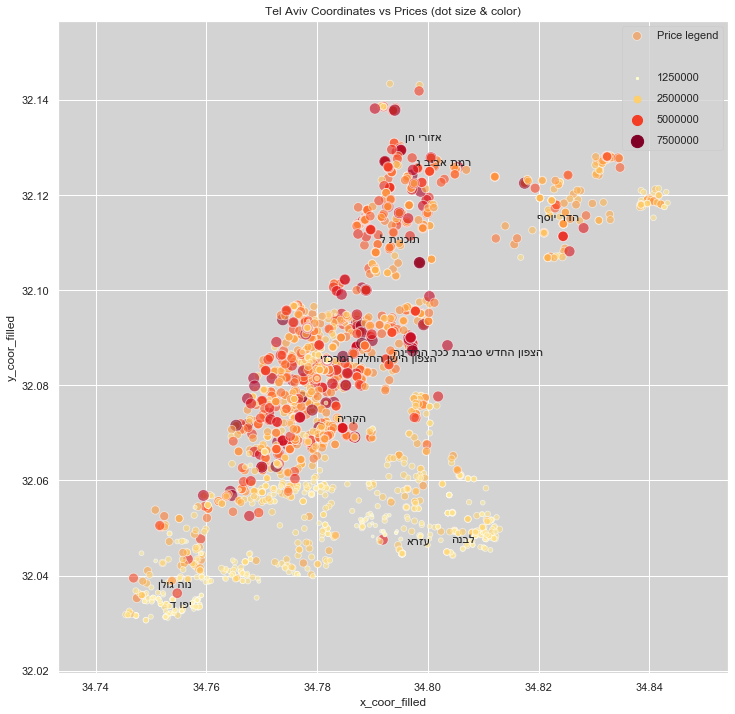

In [11]:

fig= plt.figure(figsize= (12,12))
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'lightgrey'})

sns.scatterplot(
    data=df_filtered, x='x_coor_filled', y='y_coor_filled', size="price", palette = "YlOrRd" ,alpha=0.6,
    sizes=(5, 150), hue= df_filtered.price).set_title('Tel Aviv Coordinates vs Prices (dot size & color)')


plt.legend(scatterpoints=1, frameon=True, labelspacing=1, labels=['Price legend','','1250000', '2500000','5000000','7500000'] )

xx=list(df_filtered['x_coor_filled'].values)
yy=list(df_filtered['y_coor_filled'].values)
labels= pd.Series(df_filtered.hood_filled.values).str[::-1]

for i in range(len(xx))  :                       
    annot= plt.annotate( labels[i] ,xy=(xx[i], yy[i]), xytext=(xx[i]+0.0008, yy[i]+0.002) )
    if i%225 != 0:
        annot.set_visible(False)


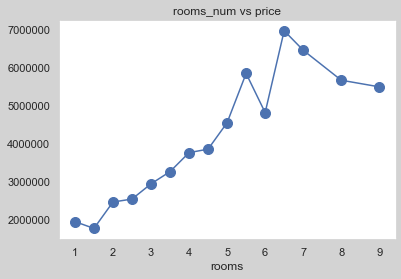

In [12]:
# rooms price rise is linear up to 7 rooms:
fig= plt.figure()
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

plot_rooms= df_filtered.groupby(['rooms'])['price'].mean()

ax= plot_rooms.plot(kind= 'line', marker= 'o', markersize= 10, title= 'rooms_num vs price', grid=True)

hide_toggle() 

In [13]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('precision',2)

df_filtered[['y_coor_filled', 'x_coor_filled', 'size_opt', 'floor_num','price']] .corr().round(2).style.background_gradient(cmap='Oranges')


,y_coor_filled,x_coor_filled,size_opt,floor_num,price
y_coor_filled,1.00,0.57,0.42,0.09,0.56
x_coor_filled,0.57,1.00,0.30,0.15,0.11
size_opt,0.42,0.30,1.00,0.25,0.68
floor_num,0.09,0.15,0.25,1.00,0.25
price,0.56,0.11,0.68,0.25,1.00


Correlation matrix reveals strong dependency between y_coor and size with price

-----

**KNN model**

first we will try a simple knn model without the extra features added along the way:

-  only 4 features were chosen - x and y coordinates, size and floor number

-  k was optimized to 6 neighbours (see graph below)

-  scaling was preformed with StandardScaler 

we get vey nice linear fit to our predicitions (R^2 = 0.798)

In [14]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# knn


X_knn= df_filtered[['y_coor_filled', 'x_coor_filled', 'size_opt', 'floor_num']] 

y_knn= df_filtered['price']

X_train_knn, X_test_knn ,y_train_knn, y_test_knn = split(X_knn, y_knn, test_size= 0.3, random_state=123)
  

#optimum -lowest error-   k = 10       ### note: first scale then run hyperparameter search!

from sklearn.preprocessing import MinMaxScaler

scaler_knn = StandardScaler()

X_train_knn_scaled = scaler_knn.fit_transform(X_train_knn)          ### note: fit_transform on train , tansform on test!
X_train_knn = pd.DataFrame(X_train_knn_scaled)   # scaler produces an array so must be datafrmaed

X_test_knn_scaled = scaler_knn.transform(X_test_knn)
X_test_knn= pd.DataFrame(X_test_knn_scaled)


# rmse_val = [] #to store rmse values for different k
# for K in range(12):
#     K = K+1
#     model = neighbors.KNeighborsRegressor(n_neighbors = K)
    
#     model.fit(X_train_knn, y_train_knn)  #fit the model
#     pred=model.predict(X_test_knn) #make prediction on test set
#     error = sqrt(mean_squared_error(y_test_knn ,pred)) #calculate rmse
#     rmse_val.append(error) #store rmse values
#     print('RMSE value for k= ' , K , 'is:', error)
    
# X_test_knn.sample(3)

model_knn = KNeighborsRegressor()



param_grid = {
                "n_neighbors":[2,3,4,5,6,7,8,9,10,11,12]

              } 

grid_search_test = GridSearchCV (model_knn ,         #The base estimator
                              param_grid, #the searching space 
                              cv =8,      #number of folds in cross validation
                              scoring = "neg_mean_squared_error", #What do we define as "good" model"?
                              verbose=1
                              )

#model_knn.fit(X_train_knn, y_train_knn)

grid_search_test.fit(X_train_knn,y_train_knn)

#pd.DataFrame(grid_search_knn.cv_results_)
cv_scores = cross_val_score(grid_search_test, X_train_knn, y_train_knn)



Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    1.2s finished


In [15]:
pd.DataFrame(grid_search_test.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01,0.00,0.01,0.00,2,{'n_neighbors': 2},-500233186977.57,-319169587804.88,-382197580487.80,-370807478048.78,-423977679121.95,-467255559756.10,-525792204536.59,-626089927561.27,-451940400536.87,92334655332.69,11
1,0.01,0.00,0.01,0.00,3,{'n_neighbors': 3},-380045085075.13,-324696908184.50,-351849155273.71,-379209704130.30,-386044452536.59,-447958180487.80,-495664013620.81,-561248791301.74,-415839536326.32,74548547778.94,10
2,0.01,0.00,0.01,0.00,4,{'n_neighbors': 4},-377654373809.88,-323075836036.71,-342150443536.59,-307153356548.90,-370418667036.71,-436519387500.00,-500304621186.10,-549780870983.46,-400882194579.79,81456695184.72,9
3,0.01,0.00,0.01,0.00,5,{'n_neighbors': 5},-389816420897.57,-341419620058.61,-321432901998.05,-288466095071.30,-369514364950.32,-435217274341.46,-521253676158.21,-532574719603.92,-399961884134.93,84110118318.42,8
4,0.01,0.00,0.01,0.00,6,{'n_neighbors': 6},-388356897472.15,-343594382439.08,-323270037902.44,-299212164777.89,-360369393607.10,-422051234552.85,-487600070004.17,-510226911586.33,-391835136542.75,71335559672.16,1
5,0.01,0.00,0.01,0.00,7,{'n_neighbors': 7},-397827847164.72,-346795128621.24,-322051809178.74,-305446217732.28,-349096700399.24,-432312679243.40,-471586734577.48,-517121986613.65,-392779887941.35,70633074848.67,2
6,0.01,0.00,0.01,0.00,8,{'n_neighbors': 8},-386621448350.28,-357766074740.88,-332391042765.27,-300568147948.23,-370457951914.66,-446347962423.78,-480002637502.35,-513709433164.06,-398483087351.19,69599811080.66,7
7,0.01,0.00,0.01,0.00,9,{'n_neighbors': 9},-377072204672.24,-354291502752.21,-333957994864.22,-302482633026.25,-380041967418.87,-452280098127.09,-468374102829.94,-493705911646.09,-395275801917.11,64123842078.04,3
8,0.01,0.00,0.01,0.00,10,{'n_neighbors': 10},-386686118562.44,-352298960429.29,-329584032492.70,-306772849301.52,-395581176357.09,-457737748599.53,-451527439415.18,-500559123285.78,-397593431055.44,63419648014.38,6
9,0.01,0.00,0.01,0.00,11,{'n_neighbors': 11},-377266938647.79,-348782365789.17,-329306114024.61,-310803338902.69,-402257667294.11,-448375573517.05,-443477159945.62,-506479560926.51,-395843589880.94,62778335777.50,4


after running grid search we see that best hyperparameter for n_neighbours is 6 


 score knn=0.7987104897743837

error_test= 584064.140918212
error_train= 525685.0446741104


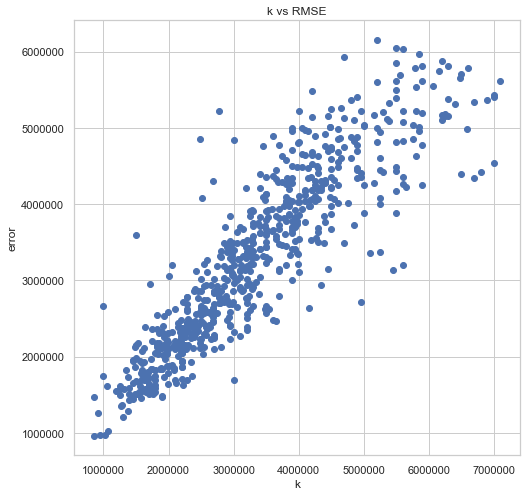

In [16]:
sns.set_style("whitegrid")
k=np.array(range(1,13))

#f, (ax2, ax1) = plt.subplots(1, 1, figsize=(15,8))

#ax1.plot(k,rmse_val)

model = neighbors.KNeighborsRegressor(n_neighbors = 6)

model.fit(X_train_knn, y_train_knn)  #fit the model
y_test_knn_pred=model.predict(X_test_knn)
y_train_knn_pred=model.predict(X_train_knn)

fig= plt.figure(figsize=(8,8))
ax1=plt.gca()
ax1.scatter(y_test_knn, y_test_knn_pred)
score_knn = r2_score(y_test_knn , y_test_knn_pred)
print(f"\n score knn={score_knn}")

ax1.set_title('k vs RMSE')
#ax2.set_title('knn model tel-aviv')

ax1.set_xlabel('k')
ax1.set_ylabel('error')
#ax2.set_xlabel('price')
#ax2.set_ylabel('price predicted')

error_test1= np.sqrt(mean_squared_error(y_test_knn , y_test_knn_pred ))

error_train1= np.sqrt(mean_squared_error(y_train_knn , y_train_knn_pred ))
print('\nerror_test=',error_test1)
print('error_train=',error_train1)

hide_toggle() 
plt.show()


**regreesion model** 

-  easterns/western feature was added
-  top_floor feature was added 
-  hood_calss was transformed with get_dummies to numerical
-  top_floor and rooms were left numerical (we tried get_dummies and it did not improve the model)

fit is OK, but worse than knn, only 0.772 for R^2


                                  0
rooms                      28088.23
floor_num                  17216.66
top_floor                -135472.93
size_opt                   26512.72
y_coor_filled            -790601.79
x_coor_filled           -9355383.43
eastern                  -437808.59
southern                 -670092.43
hood_class_lower         -895695.10
hood_class_lower_middle  -571225.43
hood_class_middle         322773.37
hood_class_upper         1112134.20
hood_class_upper_middle   478520.19

R^2= 0.7724825802089217

error_test= 620950.9538802681
error_train= 640170.0275943036


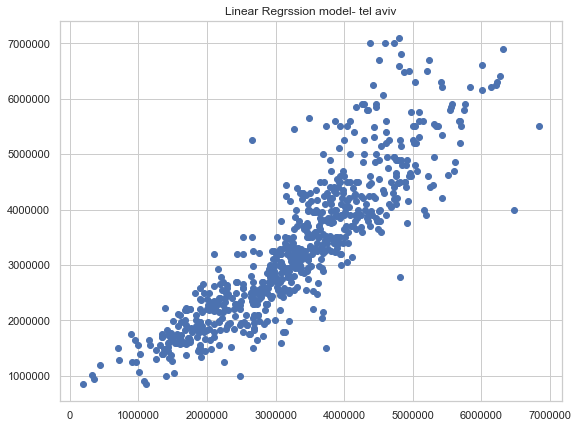

In [17]:

##### regression model #####

X= df_filtered[['rooms', 'floor_num', 'top_floor', 'size_opt', 'hood_class', 'y_coor_filled', 'x_coor_filled', 'eastern', 'southern']] 

y= df_filtered['price']

X=pd.get_dummies(X)


X_train, X_test ,y_train, y_test = split(X, y, test_size= 0.3, random_state=123)
    
prices_lm = LinearRegression ()

prices_lm.fit(X_train,y_train)

y_test_pred = prices_lm.predict(X_test)
y_train_pred = prices_lm.predict(X_train)

fig = plt.figure(figsize=(9,7))
plt.scatter(y_test_pred, y_test)
plt.title ('Linear Regrssion model- tel aviv')

from sklearn.metrics import r2_score

score2 = r2_score(y_test , y_test_pred)


y_pred= prices_lm.predict(X)

X['prediction']= y_pred
X['price']= y

weights= pd.DataFrame(prices_lm.coef_, X.columns[:-2])

error_test2= np.sqrt(mean_squared_error(y_test , y_test_pred ))

error_train2= np.sqrt(mean_squared_error(y_train , y_train_pred ))

print(weights)
print('\nR^2=',score2)
print('\nerror_test=',error_test2)
print('error_train=',error_train2)

hide_toggle() 


**Enhanced model:  Linear Regression with knn predictons feature**

-  knn fit on the second external table gives predictions for our data table

   this will be uses as a feature for a linear regression model


-  also we will build a secobd model by using logaritmic transformation for the price in order to reduce outlire's effect on the model




                                     0
rooms                      37203.35868
floor_num                   2981.28915
top_floor                -109473.57763
size_opt                   10067.63231
y_coor_filled           -1561846.61733
x_coor_filled           -2696599.03149
eastern                  -285966.78964
southern                 -229928.27897
preds_n4                       0.62635
hood_class_lower         -584895.10206
hood_class_lower_middle  -432956.57294
hood_class_middle          22848.40291
hood_class_upper          398929.18661
hood_class_upper_middle    55710.51409

R^2= 0.8209231182063379

error_test= 550896.145101792
error_train= 582508.6672080486


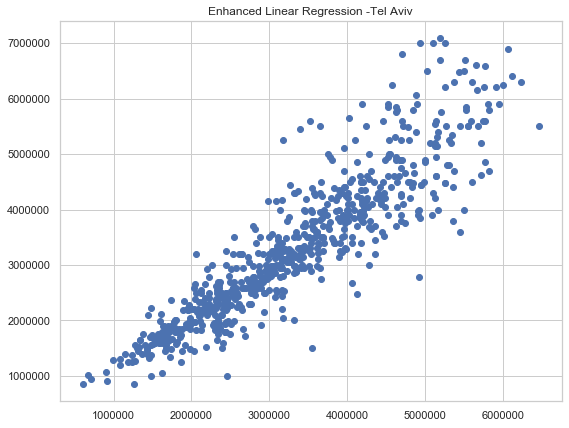

In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
pd.options.display.float_format = '{:.5f}'.format


X_train_knn= train_table[['y_coor_filled', 'x_coor_filled','size_opt', 'floor_num']]

y_train_knn= train_table['price']


scaler = StandardScaler().fit(X_train_knn)
#scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.transform(X_train_knn)

X_train = pd.DataFrame(X_train_scaled)

model_knn = KNeighborsRegressor(n_neighbors = 10)

model_knn.fit(X_train_scaled, y_train_knn)  #fit the model

model_knn.predict(X_train_knn)


# add the model predictions as a feautre to our original data:

X_test= df_filtered[['y_coor_filled', 'x_coor_filled','size_opt', 'floor_num']]

X_test_scaled = scaler.transform(X_test)

X_test  = pd.DataFrame(X_test_scaled)


np.log(2000000) # this is actuallt ln not log

df_filtered['preds_n4']=model_knn.predict(X_test)


##### regression model #####

X= df_filtered[['rooms', 'floor_num', 'top_floor', 'size_opt', 'hood_class', 'y_coor_filled', 'x_coor_filled', 'eastern', 'southern', 'preds_n4']] 

y= df_filtered['price']

X=pd.get_dummies(X)


X_train_comb, X_test_comb ,y_train_comb, y_test_comb = split(X, y, test_size= 0.3, random_state=123)
    
prices_lm = LinearRegression ()

prices_lm.fit(X_train_comb,y_train_comb)

y_test_pred = prices_lm.predict(X_test_comb)
y_train_pred = prices_lm.predict(X_train_comb)


#0.8383247839177977
fig = plt.figure(figsize=(9,7))
plt.scatter(y_test_pred, y_test_comb)
plt.title ('Enhanced Linear Regression -Tel Aviv')


from sklearn.metrics import r2_score

score3 = r2_score(y_test_comb , y_test_pred)


y_pred= prices_lm.predict(X)

X['prediction']= y_pred
X['price']= y

 
X.columns
weights= pd.DataFrame(prices_lm.coef_, X.columns[:-2])

error_test3= np.sqrt(mean_squared_error(y_test_comb, y_test_pred))

error_train3= np.sqrt(mean_squared_error(y_train_comb , y_train_pred) )

print(weights)
print('\nR^2=',score3)
print('\nerror_test=',error_test3)
print('error_train=',error_train3)

hide_toggle() 


---

**The Enhanced model with Log prices**


In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
pd.options.display.float_format = '{:.5f}'.format
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

train_table_log= train_table.iloc[:,:].assign(price=np.log(train_table['price']))
df_filtered_log= df_filtered.iloc[:,:].assign(price=np.log(df_filtered['price']))



X_train_knn= train_table_log[['y_coor_filled', 'x_coor_filled','size_opt', 'floor_num']]

y_train_knn= train_table_log['price']

ta_scaler = StandardScaler().fit(X_train_knn)

X_train_scaled = ta_scaler.transform(X_train_knn)

X_train = pd.DataFrame(X_train_scaled)


model_knn_log = KNeighborsRegressor()

#model_knn_log.fit(X_train, y_train_knn)

param_grid = {
                "n_neighbors":[2,3,4,5,6,7,8,9,10,11,12]

              } 

grid_search_knn = GridSearchCV (model_knn_log ,         #The base estimator
                              param_grid, #the searching space 
                              cv =2,      #number of folds in cross validation
                              scoring = "neg_mean_squared_error", #What do we define as "good" model"?
                              verbose=0
                              )

grid_search_knn.fit(X_train,y_train_knn)
#pd.DataFrame(grid_search_knn.cv_results_)
cv_scores = cross_val_score(grid_search_knn, X_train, y_train_knn)




In [20]:
result= pd.DataFrame(grid_search_knn.cv_results_)

result

grid_search_knn.best_estimator_

KNeighborsRegressor(n_neighbors=12)

In [21]:
X_test= df_filtered_log[['y_coor_filled', 'x_coor_filled','size_opt', 'floor_num']]

X_test_scaled = ta_scaler.transform(X_test)

X_test  = pd.DataFrame(X_test_scaled)


np.log(2000000) # this is actuallt ln not log

df_filtered_log['preds_n4']=grid_search_knn.best_estimator_.predict(X_test)



In [22]:

X= df_filtered_log[['rooms', 'floor_num', 'top_floor', 'size_opt', 'hood_class', 'y_coor_filled', 'x_coor_filled', 'eastern','southern', 'preds_n4']] 

y= df_filtered_log['price']

X=pd.get_dummies(X)

dummies_df= X.columns

X_train_comb, X_test_comb ,y_train_comb, y_test_comb = split(X, y, test_size= 0.3, random_state=123)
    

from sklearn.model_selection import cross_val_score

prices_lm = LinearRegression ()

prices_lm.fit(X_train_comb,y_train_comb)

cross= cross_val_score (prices_lm, X_train_comb, y_train_comb, cv=6)

prices_lm.score(X_test_comb, y_test_comb)

rsd= (cross.std()/cross.mean())* 100
print('cross validation output= ',cross) 
print('\nrsd= ',rsd)

hide_toggle()

cross validation output=  [0.82977394 0.83313648 0.86240647 0.80449082 0.8577192  0.81645817]

rsd=  2.479945534656325



R^2= 0.8517486869708757

error_test= 555980.3533421736
error_train= 578184.2096356557


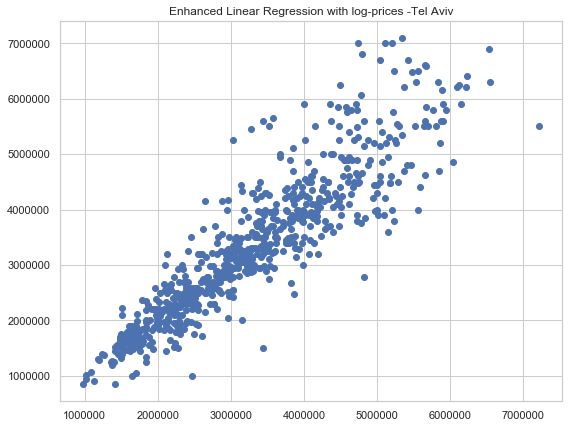

In [23]:


prices_lm.fit(X_train_comb,y_train_comb)

y_test_pred = prices_lm.predict(X_test_comb)
y_train_pred = prices_lm.predict(X_train_comb)


#0.8383247839177977

fig = plt.figure(figsize=(9,7))
plt.scatter(np.exp(y_test_pred), np.exp(y_test_comb))
plt.title ('Enhanced Linear Regression with log-prices -Tel Aviv')


from sklearn.metrics import r2_score

score4 = r2_score(y_test_comb , y_test_pred)


y_pred= prices_lm.predict(X)

X['prediction']= np.exp(y_pred)
X['price']= np.exp(y)

 
X.columns
weights= pd.DataFrame(prices_lm.coef_, X.columns[:-2])

error_test4= np.sqrt(mean_squared_error(np.exp(y_test_comb) , np.exp(y_test_pred) ))

error_train4= np.sqrt(mean_squared_error(np.exp(y_train_comb) , np.exp(y_train_pred) ))

print('\nR^2=',score4)
print('\nerror_test=',error_test4)
print('error_train=',error_train4)

hide_toggle()

conclusion: best model is the log-linear one- best fit (0.860) and small errors in the test set. we also cross validated it.

In [24]:
pd.set_option('precision',1)
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('precision',2)
import decimal

knn =[error_train1,  error_test1, score_knn]
linear_reg =[error_train2, error_train2 ,score2]
linear_reg_knn=[error_train3,  error_test3, score3]
linear_reg_knn_log= [error_train4,  error_test4, score4]


review_table = pd.DataFrame([knn, linear_reg, linear_reg_knn, linear_reg_knn_log], columns=['error_train', 'error_test', 'R^2'], index= ['knn', 'linear_reg', 'linear_reg_knn', 'linear_reg_knn_log'])
review_table[['error_train', 'error_test']]=review_table[['error_train', 'error_test']].applymap( lambda x: round(decimal.Decimal(x),0)   )

review_table=review_table[[ 'R^2','error_train', 'error_test']]
print(review_table.to_markdown())

hide_toggle()

|                    |      R^2 |   error_train |   error_test |
|:-------------------|---------:|--------------:|-------------:|
| knn                | 0.79871  |        525685 |       584064 |
| linear_reg         | 0.772483 |        640170 |       640170 |
| linear_reg_knn     | 0.820923 |        582509 |       550896 |
| linear_reg_knn_log | 0.851749 |        578184 |       555980 |


---

## KNN Modeling for all 24 Cities 

As we saw earlier knn can give a great fit out-of-the box for tel-aviv's apartment prices.
but is it that great really?
can it work for different cities too?

we will check it for all 24 cities scraped in the beginning.  
we will fit a model for every city using the loop below and draw a plot to show prediction vs true values

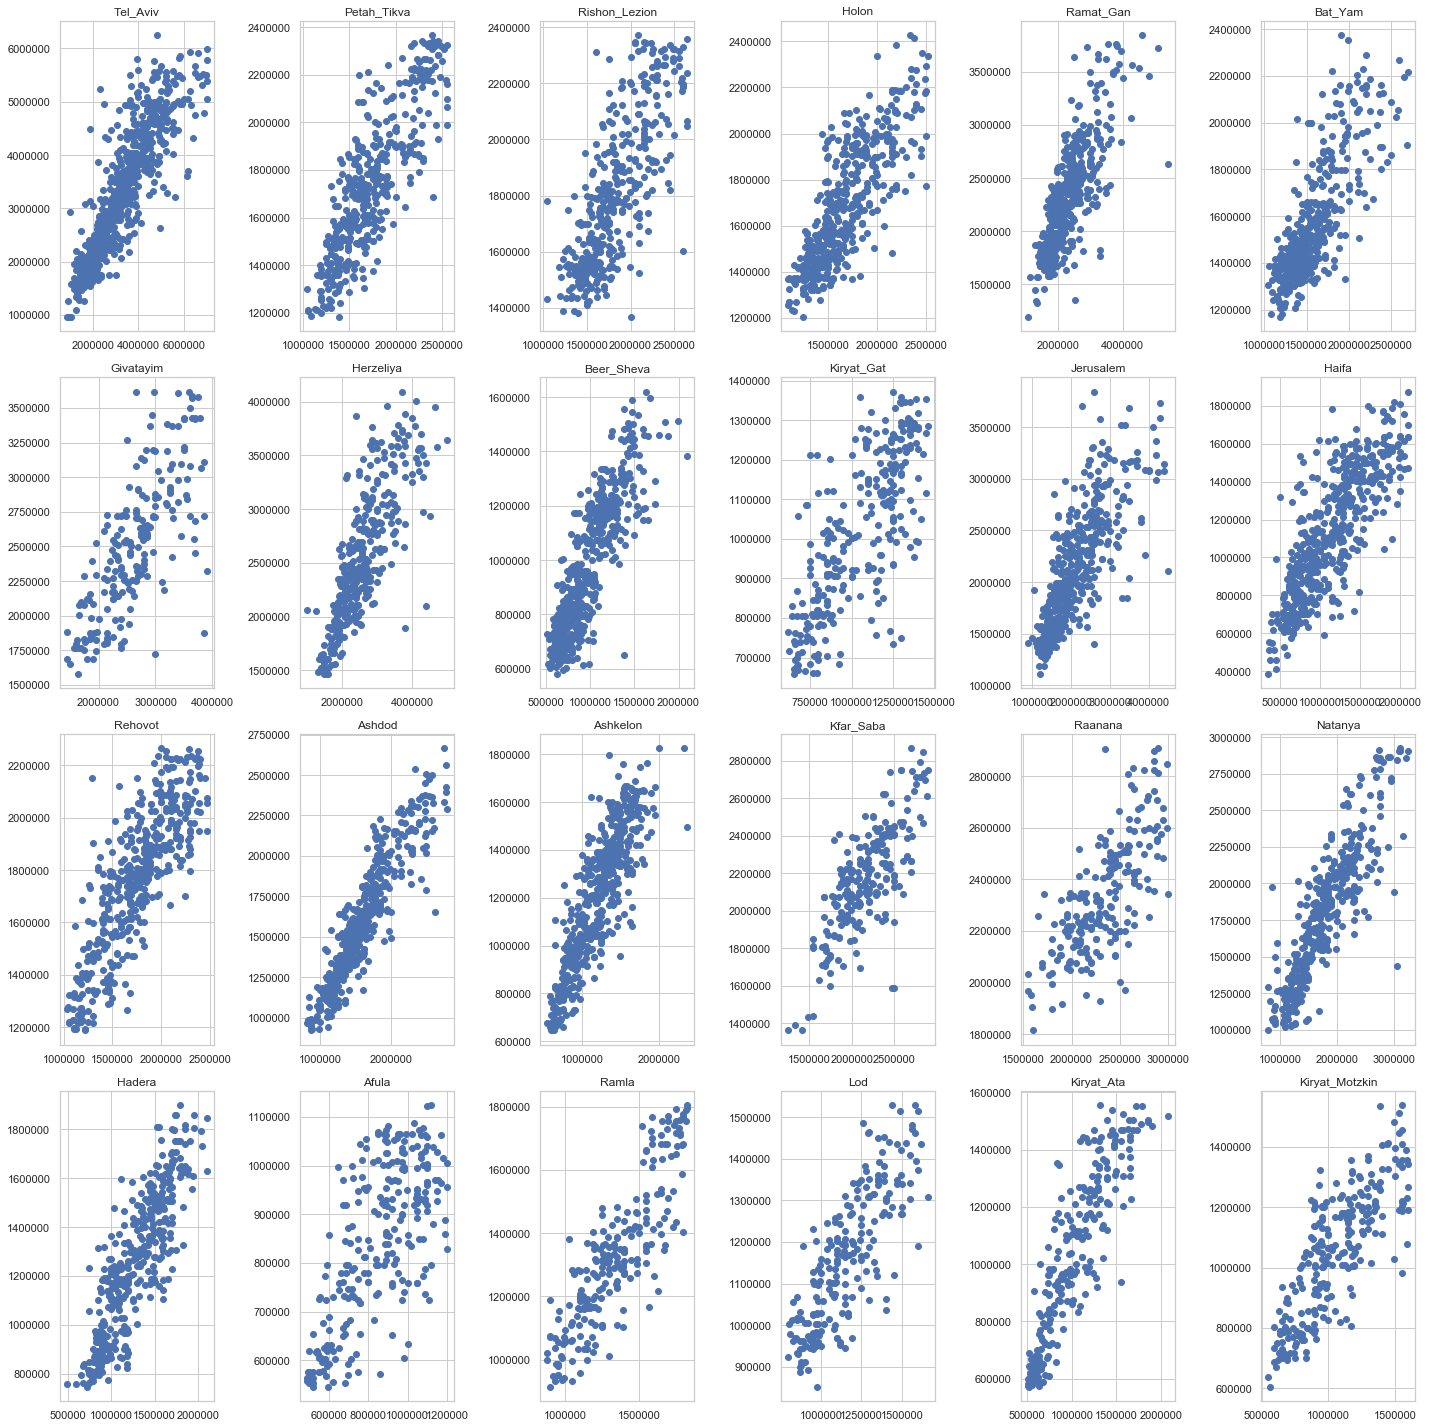

In [25]:
import warnings
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

f, ax2 = plt.subplots(4, 6, figsize=(20,20))
ax2 = ax2.ravel()
df_rev= pd.DataFrame()

l=0

# retreiving table from excel :
cities_names=  ['Tel_Aviv', 'Petah_Tikva','Rishon_Lezion','Holon' ,
                'Ramat_Gan','Bat_Yam','Givatayim','Herzeliya',
                'Beer_Sheva','Kiryat_Gat','Jerusalem', 'Haifa',
                'Rehovot','Ashdod','Ashkelon','Kfar_Saba','Raanana',
               'Natanya','Hadera', 'Afula','Ramla','Lod','Kiryat_Ata','Kiryat_Motzkin'] 


cities_dict= {}
ax_dict= {}

path = 'C://Users//shpri//Desktop//Data Science//roy_exe//real_estate_tables_updated//knn_tables'

for j in cities_names : 
    
    cities_dict[j]= pd.read_excel (path+f'//{j}_real_estate.xlsx')
    
#n_list=[]

for i in cities_names:

    df_filtered2 = cities_dict[i]

        
                              ## KNN-modeling ##
    
    X= df_filtered2[['y_coor_filled', 'x_coor_filled', 'size_opt', 'floor_num']] 
    
    y= df_filtered2['price']
    
    X_train, X_test ,y_train, y_test = split(X, y, test_size= 0.3, random_state=1234)
      
   
    rmse_val = [] #to store rmse values for different k
    for K in range(12):
        K = K+1
        model = neighbors.KNeighborsRegressor(n_neighbors = K)
        
        model.fit(X_train, y_train)  #fit the model
        pred=model.predict(X_test) #make prediction on test set
        error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
        rmse_val.append(error) #store rmse values

    n= pd.Series(rmse_val).idxmin() +1 
    n_min=pd.Series(rmse_val).min()
    
    k=np.array(range(1,13))

    
    from sklearn.preprocessing import MinMaxScaler
    
    scaler_knn = StandardScaler()
    
    X_train_scaled = scaler_knn.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled)
    
    X_test_scaled = scaler_knn.transform(X_test)
    X_test= pd.DataFrame(X_test_scaled)
    
    model = neighbors.KNeighborsRegressor(n_neighbors = n)
    
    model.fit(X_train, y_train)  #fit the model
    y_test_pred=model.predict(X_test)
    y_train_pred=model.predict(X_train)
    
    
    ax2[l].scatter(y_test, y_test_pred)
    ax2[l].set_title(i)
    score_knn = r2_score(y_test , y_test_pred)

    l= l+1
    
    sizer= df_filtered2[ 'size_opt'].count()
    
    error_test= np.sqrt(mean_squared_error(y_test , y_test_pred ))
    
    error_train= np.sqrt(mean_squared_error(y_train , y_train_pred ))

    row= pd.Series([score_knn, error_train, error_test, n, sizer], index=['R^2','error_train','error_test', 'k', 'records'], name=i)
    df_rev=df_rev.append(row)
    
f.tight_layout()

plt.show()
    
hide_toggle()

the table below concludes that only 8 out of 24 cities have a good fit (over 0.7) ,
so we think, like we saw before, using linear regression is important for getting better predicitions

In [26]:

pd.options.display.float_format = '{:.3f}'.format

df_rev.sort_values('R^2',ascending=False)

,R^2,error_test,error_train,k,records
Ashdod,0.835,173865.107,158160.798,9.000,1449.000
Kiryat_Ata,0.785,167420.015,164501.595,11.000,840.000
Tel_Aviv,0.773,626828.086,512587.326,6.000,2342.000
Natanya,0.765,247254.013,229072.814,12.000,1417.000
Beer_Sheva,0.744,144475.471,128905.988,10.000,1791.000
Ramla,0.740,130315.921,116806.366,9.000,788.000
Hadera,0.737,170806.582,143410.075,6.000,1349.000
Ashkelon,0.726,168646.775,168049.272,12.000,1709.000
Petah_Tikva,0.698,195372.704,185252.517,11.000,1367.000
Rehovot,0.677,198883.718,176704.284,12.000,1526.000


------

## Predicting transactions prices from "Madlan" website##

we took 200 records of apartments transactions from Madlan's website :  https://www.madlan.co.il/area-info - all from the year 2020, in Tel Aviv. 

first we cleaned madlan's record table and modified it to fit our model (we didn't have neighborhoods names so that was filled with the coordinates like above) 

the cleaned and modified table is shown below


In [27]:
df_madlan= pd.read_excel(r'C:\Users\shpri\Desktop\Data Science\roy_exe\Madlan_Tel_Aviv_real_estate_test2.xlsx')
df_madlan['hood_class'] =df_madlan['hood_filled'].map(df_hoods['hood_class'])

df_madlan= df_madlan[df_madlan['price']>999999]
                     
df_madlan= df_madlan.dropna()

df_madlan= df_madlan[df_madlan['entry_date'] >1950]

df_madlan['price']=np.log(df_madlan['price'])

df_madlan

,Unnamed: 0,date_ad,price,region,rooms,address,city,type,floor_num,top_floor,size_opt,hood_filled,entry_date,full_address,y_coor_filled,x_coor_filled,eastern,southern,hood_class
0,0,'6.7.2020',14.979,Tel_Aviv_Jaffa,4.000,"""המלך גורג 24""",tel aviv,דירה,3,False,66.000,לב תל אביב החלק הצפוני,1960,"""המלך גורג 24 תל אביב""",32.072,34.774,False,False,upper_middle
2,2,'7.7.2020',14.972,Tel_Aviv_Jaffa,2.500,"""זבוטינסקי 111""",tel aviv,דירה,2,False,54.000,הצפון החדש סביבת ככר המדינה,1960,"""זבוטינסקי 111"" תל אביב",32.088,34.786,False,False,upper_middle
3,3,'9.6.2020',14.712,Tel_Aviv_Jaffa,3.000,"""זבוטינסקי 103""",tel aviv,דירה,3,False,69.000,הצפון החדש סביבת ככר המדינה,1960,"""זבוטינסקי 103"" תל אביב",32.088,34.785,False,False,upper_middle
4,4,'26.5.2020',14.221,Tel_Aviv_Jaffa,1.000,"""יוניצמן 21""",tel aviv,דירה,13,False,22.000,חוף הצוק,1989,"""יוניצמן 21"" תל אביב",32.143,34.793,False,False,upper_middle
7,7,'27.5.2020',14.790,Tel_Aviv_Jaffa,2.500,אבן גבירול 164,tel aviv,דירה,4,False,56.000,הצפון הישן החלק הצפוני,1960,אבן גבירול 164 תל אביב,32.091,34.783,False,False,middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,287,'7.8.2020',13.998,Tel_Aviv_Jaffa,3.000,שקד 38,tel aviv,דירה,3,False,66.000,תל כביר,1960,שקד 38 תל אביב,32.041,34.763,False,True,lower
288,288,'22.9.2020',14.234,Tel_Aviv_Jaffa,4.000,ששת הימים 5,tel aviv,דירה,3,False,48.000,לבנה,1960,ששת הימים 5 תל אביב,32.007,34.796,False,True,lower
289,289,'13.5.2020',14.221,Tel_Aviv_Jaffa,3.000,ששת הימים 4,tel aviv,דירה,3,False,63.000,לבנה,1970,ששת הימים 4 תל אביב,32.007,34.796,False,True,lower
291,291,'16.6.2020',14.972,Tel_Aviv_Jaffa,3.000,תל חי 3,tel aviv,דירה,1,False,73.000,הצפון הישן החלק הדרום מזרחי,1980,תל חי 3 תל אביב,32.077,34.776,False,False,middle


we tried to reach the predicted price with our best model (the log-linear-knn one).

the final results seem somehow inadequate as only about 60% of the predection had less than 15% deviation from the real transaction price

R^2=  0.5740279478437649
error=  771410.1249762294


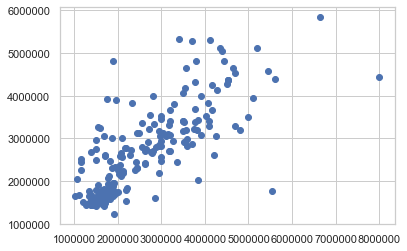

In [28]:
X_test_M= df_madlan[['y_coor_filled', 'x_coor_filled','size_opt', 'floor_num']]



X_test_M_scaled = ta_scaler.transform(X_test_M)

X_test_M  = pd.DataFrame(X_test_M_scaled)

df_madlan['preds_n4']=grid_search_knn.best_estimator_.predict(X_test_M)


y=df_madlan['price'] 
X_madlan= df_madlan[['rooms', 'floor_num', 'top_floor', 'size_opt', 'hood_class', 'y_coor_filled', 'x_coor_filled', 'eastern','southern', 'preds_n4']] 
X_madlan=pd.get_dummies(X_madlan)

X_madlan= X_madlan[['rooms', 'floor_num', 'top_floor', 'size_opt', 'y_coor_filled',
       'x_coor_filled', 'eastern', 'southern', 'preds_n4', 'hood_class_lower',
       'hood_class_lower_middle', 'hood_class_middle', 'hood_class_upper',
       'hood_class_upper_middle']]

y_pred= prices_lm.predict(X_madlan)

error_test5= np.sqrt(mean_squared_error(np.exp(y) , np.exp(y_pred) ))


from sklearn.metrics import r2_score

score5 = r2_score (np.exp(y),np.exp(y_pred))


plt.scatter(np.exp(y),np.exp(y_pred))

print("R^2= ",score5)
print("error= ",error_test5)      

hide_toggle()


In [29]:
X_madlan['y_pred']= np.exp(y_pred)
X_madlan['real_price']= np.exp(y)


X_madlan['delta_price']= abs(X_madlan['y_pred']-X_madlan['real_price'])

X_madlan['percent_delta']=100*(X_madlan['delta_price']/X_madlan['real_price'])
hits= (X_madlan['percent_delta']<=15).sum()

i=15
X_madlan['preds_n4']= np.exp(X_madlan['preds_n4'])
X_madlan['difference']=X_madlan['y_pred']-X_madlan['real_price']

bad=X_madlan [X_madlan['percent_delta']>i]  # all erorrs bigger than 30%

total_pred= len(X_madlan['percent_delta'])

delta= X_madlan['percent_delta']>i


bad_over= X_madlan [(delta) & (X_madlan['difference']>0) ]  #errors that are over-predicitons
print(f"delta= {i}%")
print("total predicitons: ",total_pred)
print("bad predictions: ", len(bad))
print("bad over-predicitons: " ,len(bad_over))

over_prediciton = len(bad_over)/len(bad)
print(f"over predictions= {over_prediciton*100} % when delta is over {i}%")

hide_toggle()


delta= 15%
total predicitons:  205
bad predictions:  87
bad over-predicitons:  57
over predictions= 65.51724137931035 % when delta is over 15%


In [30]:
df_madlan= pd.concat([df_madlan,X_madlan[[ 'preds_n4','y_pred', 'real_price', 'delta_price',
       'percent_delta', 'difference']]], axis= 1)

df_madlan_show= df_madlan[['price','rooms', 'address', 'city',
       'floor_num', 'size_opt', 'hood_filled','hood_class', 'y_pred', 'real_price', 'delta_price', 'percent_delta']]

df_madlan_show = df_madlan_show.loc[:,~df_madlan_show.columns.duplicated()]

df_madlan_show['over_prediction?']= np.where(df_madlan_show['y_pred']>df_madlan_show['real_price'], True, False)

df_madlan_show.sort_values(['percent_delta'],ascending=False).head(10)


,price,rooms,address,city,floor_num,size_opt,hood_filled,hood_class,y_pred,real_price,delta_price,percent_delta,over_prediction?
43,14.457,5.000,ברזיל 1,tel aviv,6,130.000,רמת אביב,middle,4822847.563,1900000.000,2922847.563,153.834,True
127,14.375,4.000,כרם התימנים 23,tel aviv,4,73.000,כרם התימנים,upper_middle,3914596.613,1750000.000,2164596.613,123.691,True
41,13.964,2.500,בני אפרים 210 יפו,tel aviv,1,57.000,מעוז אביב א,middle,2515357.859,1160000.000,1355357.859,116.841,True
83,13.964,3.000,הצנחנים 15,tel aviv,4,75.000,נוה שרת,middle,2457167.147,1160000.000,1297167.147,111.825,True
125,14.254,3.000,כרם התימנים 32,tel aviv,3,71.000,כרם התימנים,upper_middle,3275977.929,1550000.000,1725977.929,111.353,True
266,14.286,3.000,שדרות נורדאו 4,tel aviv,8,65.000,הצפון הישן החלק הצפוני,middle,3250661.609,1600000.000,1650661.609,103.166,True
123,14.488,3.000,כרם התימנים 48,tel aviv,6,81.000,כרם התימנים,upper_middle,3889090.349,1960000.000,1929090.349,98.423,True
119,14.221,3.000,כרם התימנים 75,tel aviv,4,60.000,כרם התימנים,upper_middle,2967446.141,1500000.000,1467446.141,97.830,True
155,13.973,3.000,מינקובסקי 4,tel aviv,1,87.000,קרית שלום,lower_middle,2257266.688,1170000.000,1087266.688,92.929,True
292,13.883,3.000,תל חיים 9,tel aviv,2,70.000,תל חיים,lower_middle,2054937.504,1070000.000,984937.504,92.050,True


we can see that all top 10 "worst" prdictions are all **over-estimations**.

this is prehaps logical as our model was based on website ads, meaning sometimes they are only "entry level" prices
while real-life prices tend to end-up lower, as people bargain many times from both ends of the deal- sellers and buyers.

so this concludes that our model is not the best estimator for trsanscation prices, as reported in madlan website.

although increasing our sampling number could have improved the results by decreasing the weight of extreme oultliers.

In any case, it is still a great estimator for the advertised price, which in many cases is just as important.


**decision trees regressor model**

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from math import radians, cos, sin, asin, sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import cross_val_score, GridSearchCV
import tqdm
from sklearn.metrics import r2_score

#df=pd.read_excel("/content/Tel_Aviv_real_estate2.xlsx")
df=pd.read_excel(r"C:\Users\shpri\Desktop\Data Science\roy_exe\real_estate_tables_updated\knn_tables\Tel_Aviv_real_estate.xlsx")
df

X = df.drop(['date_ad','hood_filled','Unnamed: 0','type',"region","full_address","address","city","price"], axis=1)
X= pd.get_dummies(X)
y = df["price"]

X_dev, X_test, y_dev, y_test = split(X, y, test_size = 0.3, random_state= 123)

dt = DecisionTreeRegressor()         #Init model with default 

#Define your "searching space", The keys are the hyperparams, values are the list (range of choices)
param_grid = {
                "max_depth" : [2,3,4,5,6,7,8,9,10],
                "max_leaf_nodes" : [7,8,9,10,11,12,13,14,15,16,17,18,19,20],
                "min_samples_leaf":[1, 2, 3, 5],
                "min_samples_split":[2,4,6]
              } 

grid_search_dt = GridSearchCV(dt,         #The base estimator
                              param_grid, #the searching space 
                              cv =4,      #number of folds in cross validation
                              scoring = "neg_mean_squared_error", #What do we define as "good" model"?
                              verbose=1
                              )
grid_search_dt.fit(X_dev, y_dev)


res= pd.DataFrame(grid_search_dt.cv_results_).sort_values('rank_test_score', ascending= True)

res

dt_2 =DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=20,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')         #Init model with default 

y_pred=dt_2.predict(X_test)

from sklearn.metrics import mean_squared_error 


mse = mean_squared_error(y_test,y_pred)

mse**0.5

score = r2_score(y_test , y_pred)

fig = plt.figure(figsize=(9,7))
plt.scatter( y_test,y_pred

SyntaxError: unexpected EOF while parsing (<ipython-input-31-9879ca4526c8>, line 64)